In [1]:
# load necessary library
suppressPackageStartupMessages(library(GEOquery))
suppressPackageStartupMessages(library(oligo))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(repr))

In [2]:
create.folders<-function(folder_names=NULL,location="."){
#     pass names or paths to create multiple folders 
#     and returns list of status as boolean

    paths<-file.path(location, folder_names)
    is_exists<-dir.exists(paths)
    paths<-paths[!is_exists]
    lapply(paths,function(path){
        dir.create(path, recursive = TRUE)
    })
    return(!is_exists)
    
}

remove.folders<-function(location=".",folder_names=NULL){
#   pass names or paths to remove multiple folders  
#   and returns list of boolean, if it now exists 
    
    paths<-file.path(location, folder_names)
    unlink(paths, recursive= T)
    return(!dir.exists(paths))
}

find.all.indeces<-function(query_list, vector){  
#   returns all matched indeces as a list.
    sapply(query_list,function(query) grep(query,vector))
}
           
extract_from_vector<-function(query_list, vector){
    store<-unique(unlist(lapply(query_list, function(query) grep(query, vector))
                  ))
    return(vector[store])
}
           
group_by_query<-function(query_names, vector, group_names=NULL){
#     it allocates group with first group name that matched if provided.
#     Otherwise allocate query name
    group<-rep(NA,length(vector))
    for(i in 1:length(vector)){
        for(j in 1:length(query_names)){
            if(is.na(group[i]) && !is.na(pmatch(query_names[j],vector[i])))
                if(!is.null(group_names) &&
                   length(group_names)==length(query_names))
                    group[i]<-group_names[j]
                else{group[i]<-query_names[j]}
            }
        }
      return(group)  
}
           
# if group_by_query fuction don't works due to query issues the use this
group_by_numbering<-function(group_numbering, vector, group_names=NULL){
#     gsub(pattern, replacement, string)
    group_numbering<- gsub(" ","",group_numbering)
    group <- rep(NA,length(vector))
    for (i in 1:nchar(group_numbering)){
        num<-as.numeric(substr(group_numbering,i,i))
        if(is.null(group_names)) 
            group[i] <- num
        else group[i] <- group_names[num]
        }
    return(group)
}
           
group_by_uniqueness<- function(vector, group_names=NULL){
    if(is.null(group_names)){
        uniq<- unique(vector)
        rename<-1:length(uniq)
        names(rename)<-uniq
        return(unname(rename[vector]))
    } 
    else {
        uniq<- unique(vector)
        names(group_names)<-uniq
        return(unname(group_names[vector]))
    }
}

fetch.geo.data<-function(GEO,filename=NULL,store_loc="."){
#     fetch published processed data and metadata from GEO database
    suppressPackageStartupMessages(library(GEOquery))
    if(!is.null(filename)) create.folders(file.path(store_loc,filename))
    else create.folders(filename)
    geo.data <- getGEO(GEO, filename=filename, destdir=store_loc, 
                     GSEMatrix=FALSE, AnnotGPL=TRUE, 
                     getGPL=TRUE)
    return(geo.data)
}

need.log.transformation<- function(data){
    qx <- as.numeric(quantile(data, c(0., 0.25, 0.5, 0.75, 0.99, 1.0), na.rm=T))
    # check if data need to be normalized 
    LogC <- (qx[5] > 100) ||
            (qx[6]-qx[1] > 50 && qx[2] > 0) ||
            (qx[2] > 0 && qx[2] < 1 && qx[4] > 1 && qx[4] < 2)
    return(LogC)
}

sort.data<- function(data,columns,dec=FALSE){
    return(data[order(data[,columns],decreasing=dec),])
}

del.duplication<- function(data,column){
    return(data[!duplicated(data[,column]),])
}
           
setup_folder<-function(id){
    # create and set working directory if not exists
    if(!identical(tail(unlist(strsplit(getwd(), split = "/")), n=1), id)){
        if(!dir.exists(id)) {
        create.folders(id)
        setwd(dir =id )
    }
    else setwd(dir =id )
} 
}

In [3]:
# declare ccession number
my.gse<-c("GSE14641")
# set working directory
# setup_folder(my.gse)
# setwd('GSE14641_Trypasoma.cruzi')
getwd()

[1] "D:/biological data analysis/final submission/histone/GSE14641_Trypasoma.cruzi"

We found Differential Gene Analysis result on geo. So we extracted only histone genes using excel and converted to proper format for ggplot use 

## ScatterPlot


In [13]:
only.histo<-read.table("results/Trypanosoma cruzi_ggplot.txt",header=T,sep="\t",quote="")
head(only.histo,5)

,ID_REF,Gene.ID,Common.Name.of.Primary.Target,logFC,stages
,<int>,<chr>,<chr>,<dbl>,<chr>
1,754,8035.t00006,histone acetyltransferase,1.50,amastigotes
2,5189,4938.t00008,histone deacetylase,0.61,amastigotes
3,5402,7192.t00027,histone deacetylase,1.52,amastigotes
4,9122,8825.t00021,histone deacetylase 1,1.03,amastigotes
5,9794,8089.t00012,histone deacetylase,0.67,amastigotes


In [14]:
unique(only.histo$stages)

[1] "amastigotes"     "trypomastigotes"

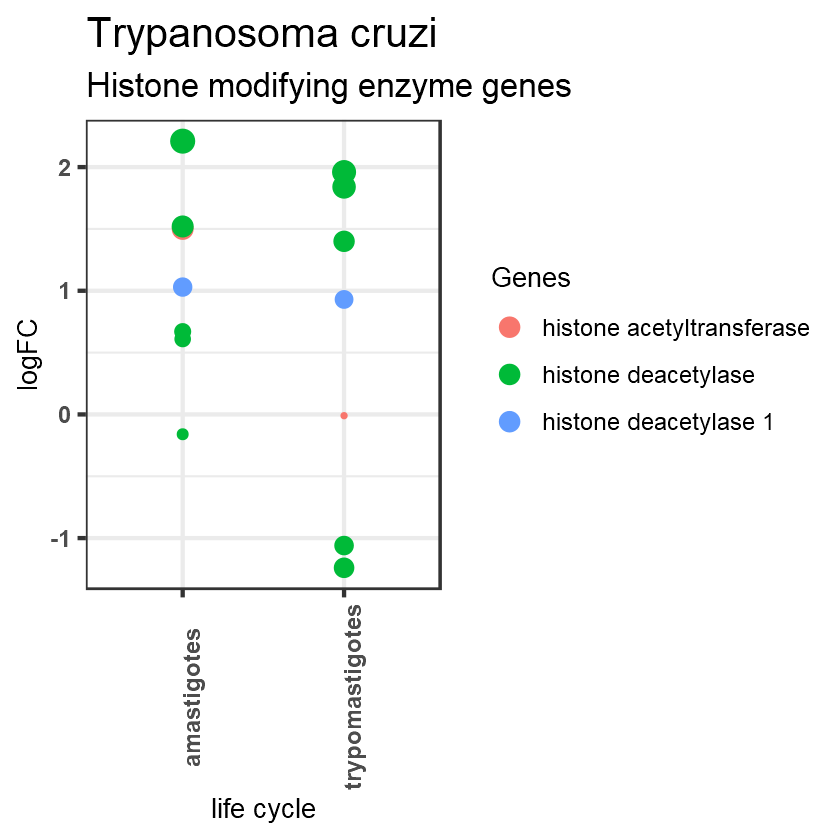

In [7]:
# svg(file="results/HistoneRelatedPLot.svg") 
# options(repr.plot.width=10,repr.plot.height=12)

theme_set(theme_bw(base_size = 20))  # pre-set the bw theme.
x_axis_order<-c('amastigotes','trypomastigotes')
size<-abs(only.histo$logFC)
# Significant<-factor(only.histo$test)
Genes<-only.histo$Common.Name.of.Primary.Target
gene.cols <- c('histone acetyltransferase' = "red", 'histone deacetylase' = "blue", 'histone deacetylase 1'= "green")
g <- ggplot(only.histo, aes(factor(stages, level = x_axis_order),
                                   logFC))+
#     geom_point(aes(fill=Genes,size=size,col=Significant),shape=21) +
      geom_point(aes(color=Genes,size=size)) +
#     scale_colour_manual(values = c("black", "gray", "black"))+
    scale_fill_manual(values=gene.cols)+

    guides(size = FALSE, fill = guide_legend(override.aes = list(size=5)),
          color = guide_legend(override.aes = list(size=5)))+
    theme(axis.text.x = element_text(face="bold",size=14,angle=90),
          axis.text.y = element_text(face="bold",size=14),
          legend.title = element_text(color="black",size = 16),
          legend.text = element_text(color = "black", size = 14),
          legend.key.size = unit(1, "cm"),
#           legend.key.size = unit(3,"line"),
          legend.key.width = unit(0.8,"cm") ,
        axis.text=element_text(size=14),
        axis.title=element_text(size=16),
          
          )+
  labs(subtitle="Histone modifying enzyme genes", 
       y="logFC",
       x="life cycle",
       title="Trypanosoma cruzi"
#        caption="life cycle"
      )
g
# dev.off()

In [8]:
# ggsave(file="results/OnlyHistonePlot.svg", plot=g, width=10, height=12)
ggsave(file="results/OnlyHistonePlot.svg", plot=g)

Saving 6.67 x 6.67 in image



In [31]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 19041)

Matrix products: default

locale:
[1] LC_COLLATE=English_India.1252  LC_CTYPE=English_India.1252   
[3] LC_MONETARY=English_India.1252 LC_NUMERIC=C                  
[5] LC_TIME=English_India.1252    

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] gdtools_0.2.3       repr_1.1.3          ggplot2_3.3.3      
 [4] oligo_1.54.1        Biostrings_2.58.0   XVector_0.30.0     
 [7] IRanges_2.24.1      S4Vectors_0.28.1    oligoClasses_1.52.0
[10] GEOquery_2.58.0     Biobase_2.49.0      BiocGenerics_0.36.0

loaded via a namespace (and not attached):
 [1] MatrixGenerics_1.2.0        tidyr_1.1.2                
 [3] bit64_4.0.5                 jsonlite_1.7.2             
 [5] splines_4.0.3               foreach_1.5.1              
 [7] BiocManager_1.30.10         blob_1.2.1    